In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "../Data"
PRICE_SCALE = 10_000
LEVELS = 10


In [2]:
msg_path = f"{DATA_DIR}/GOOG_2012-06-21_34200000_57600000_message_10.csv"
ob_path  = f"{DATA_DIR}/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv"

msg_cols = ["time", "type", "order_id", "size", "price", "direction"]
msg = pd.read_csv(msg_path, names=msg_cols)

ob_cols = []
for lvl in range(1, LEVELS + 1):
    ob_cols += [f"ask_p{lvl}", f"ask_s{lvl}", f"bid_p{lvl}", f"bid_s{lvl}"]
ob = pd.read_csv(ob_path, names=ob_cols)

df = pd.concat([msg, ob], axis=1).set_index("time").sort_index()
df.head()


,type,order_id,size,price,direction,ask_p1,ask_s1,bid_p1,bid_s1,ask_p2,...,bid_p8,bid_s8,ask_p9,ask_s9,bid_p9,bid_s9,ask_p10,ask_s10,bid_p10,bid_s10
time,,,,,,,,,,,,,,,,,,,,,
34200.015105,4,15818974,4,5794000,1,5802300,100,5794000,496,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.059902,4,15818974,300,5794000,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5795100,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5795000,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100
34200.113247,5,0,1,5794900,1,5802300,100,5794000,196,5804300,...,5762600,100,5880000,100,5732000,20,5892600,100,5700000,100


In [3]:
df["mid_d"] = (df["ask_p1"] + df["bid_p1"]) / (2 * PRICE_SCALE)
df["spread_d"] = (df["ask_p1"] - df["bid_p1"]) / PRICE_SCALE

den = (df["bid_s1"] + df["ask_s1"]).replace(0, np.nan)
df["micro_d"] = (df["ask_p1"] * df["bid_s1"] + df["bid_p1"] * df["ask_s1"]) / den / PRICE_SCALE
df["imbalance_l1"] = (df["bid_s1"] - df["ask_s1"]) / den


In [49]:
def run_mm_type4_with_quoting_rule(
    df,
    base_size=10,
    fee_per_share=0.0,
    inv_cap=200,
    refresh_events=10,
    min_spread_d=0.01,
    latency_events=0,
    inv_scale=200,   # aggressive size-skew
    min_size=1.0     # avoid going to zero size
):
    """
    Event-driven market maker using LOBSTER visible executions (type=4) with quoting rule + latency + size-skew.

    Quoting:
      - Quotes persist and are refreshed every `refresh_events` events.
      - At refresh times, decide whether to quote based on:
          * min spread filter (profitability proxy)
          * inventory-based SIZE skew (continuous inventory control)
          * hard inventory cap safety

    Fills:
      - Only on type=4 events.
      - Buy fill if direction==1 and exec price equals our quoted bid AND we are quoting bid.
      - Sell fill if direction==-1 and exec price equals our quoted ask AND we are quoting ask.
      - Fill size uses a pro-rata approximation vs L1 depth (no queue position).

    Latency:
      - `latency_events` uses stale book info when setting quotes (0 means use i-1).
    """
    n = len(df)

    bid_p = df["bid_p1"].to_numpy()
    ask_p = df["ask_p1"].to_numpy()
    bid_q = df["bid_s1"].to_numpy()
    ask_q = df["ask_s1"].to_numpy()

    m_type  = df["type"].to_numpy()
    m_price = df["price"].to_numpy()
    m_size  = df["size"].to_numpy()
    m_dir   = df["direction"].to_numpy()

    mid_d    = df["mid_d"].to_numpy()
    spread_d = df["spread_d"].to_numpy()

    inv = np.zeros(n, dtype=float)
    cash = np.zeros(n, dtype=float)
    buys = np.zeros(n, dtype=float)
    sells = np.zeros(n, dtype=float)

    cur_inv = 0.0
    cur_cash = 0.0

    # current (resting) quote state
    q_bid = np.nan
    q_ask = np.nan
    quote_bid = False
    quote_ask = False

    # size posted on each side (can be skewed)
    q_size_bid = 0.0
    q_size_ask = 0.0


    # start index must allow i-1-latency_events to be valid
    start = 1 + latency_events

    for i in range(start, n):

        # ---- refresh quotes every `refresh_events` events ----
        if (i - start) % refresh_events == 0:
            j = i - 1 - latency_events  # snapshot index used to set quotes

            # profitability filter: if spread too tight, quote nothing
            if spread_d[j] < min_spread_d:
                quote_bid = False
                quote_ask = False
                q_bid = np.nan
                q_ask = np.nan
                q_size_bid = 0.0
                q_size_ask = 0.0
            else:
                # quote at touch using stale snapshot j
                q_bid = bid_p[j]
                q_ask = ask_p[j]

                # quote both sides by default
                quote_bid = True
                quote_ask = True

                # ---- inventory-based SIZE skew (continuous) ----
                # k in [-1, 1]; long => k>0 => bid size smaller, ask size larger
                k = float(np.clip(cur_inv / inv_scale, -1.0, 1.0))
                q_size_bid = max(min_size, base_size * (1.0 - k))
                q_size_ask = max(min_size, base_size * (1.0 + k))

                # ---- hard safety cap: turn off side that worsens risk ----
                if cur_inv >= inv_cap:
                    quote_bid = False
                    q_size_bid = 0.0
                if cur_inv <= -inv_cap:
                    quote_ask = False
                    q_size_ask = 0.0

        # ---- fills happen only if we are quoting that side ----
        if m_type[i] == 4:
            # BUY fill on bid (direction==1 => execution at bid side)
            if quote_bid and (m_dir[i] == 1) and (m_price[i] == q_bid) and (bid_q[i-1] > 0):
                pre_depth = bid_q[i-1]
                exec_sz = m_size[i]
                fill = min(q_size_bid, exec_sz * (q_size_bid / pre_depth))
                px = q_bid / PRICE_SCALE

                cur_inv += fill
                cur_cash -= fill * px
                cur_cash -= fee_per_share * fill
                buys[i] = fill

            # SELL fill on ask (direction==-1 => execution at ask side)
            if quote_ask and (m_dir[i] == -1) and (m_price[i] == q_ask) and (ask_q[i-1] > 0):
                pre_depth = ask_q[i-1]
                exec_sz = m_size[i]
                fill = min(q_size_ask, exec_sz * (q_size_ask / pre_depth))
                px = q_ask / PRICE_SCALE

                cur_inv -= fill
                cur_cash += fill * px
                cur_cash -= fee_per_share * fill
                sells[i] = fill

        inv[i] = cur_inv
        cash[i] = cur_cash


    equity = cash + inv * mid_d

    return pd.DataFrame(
        {"inventory": inv, "cash": cash, "equity": equity, "buys": buys, "sells": sells},
        index=df.index
    )




In [58]:
res_quote = run_mm_type4_with_quoting_rule(
    df,
    base_size=10,
    fee_per_share=0.0005,
    inv_cap=200,
    refresh_events=10,
    min_spread_d=0.01,
    latency_events=10,   
    inv_scale=100,      # 100 is almost aggressive
    min_size=1.0
)

print("Total buys:", res_quote["buys"].sum())
print("Total sells:", res_quote["sells"].sum())
print("Final equity:", res_quote["equity"].iloc[-1])
print("Max abs inventory:", res_quote["inventory"].abs().max())




Total buys: 9846.634787011972
Total sells: 9864.202189449388
Final equity: 51.18516973430087
Max abs inventory: 90.34641804182233


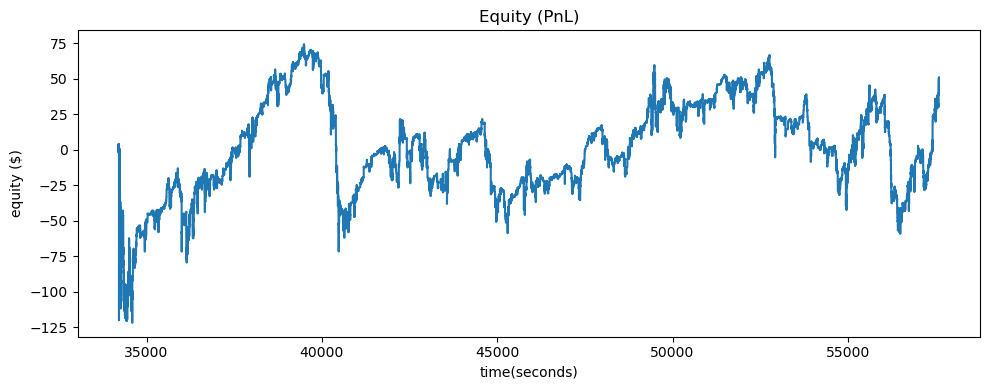

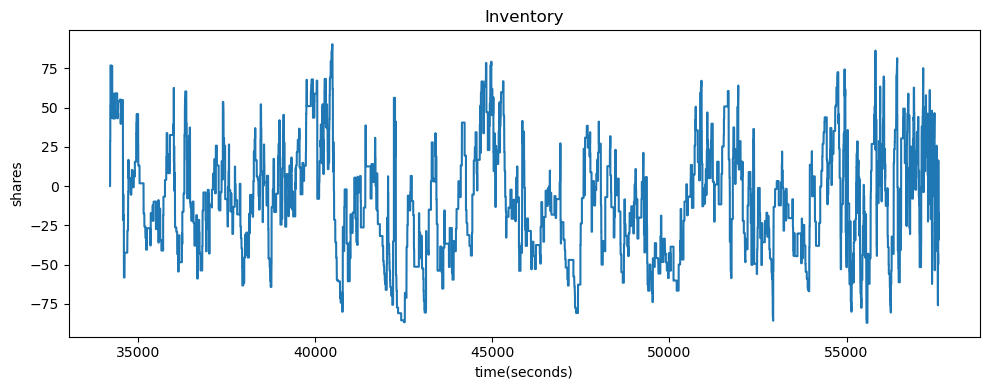

In [59]:
N = 200000

fig, ax = plt.subplots(figsize=(10,4))
res_quote["equity"].iloc[:N].plot(ax=ax)
ax.set_title("Equity (PnL)")
ax.set_xlabel("time(seconds)")
ax.set_ylabel("equity ($)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
res_quote["inventory"].iloc[:N].plot(ax=ax)
ax.set_title("Inventory")
ax.set_xlabel("time(seconds)")
ax.set_ylabel("shares")
plt.tight_layout()
plt.show()


In [60]:
def compute_metrics(res: pd.DataFrame) -> dict:
    equity = res["equity"].to_numpy()
    inv = res["inventory"].to_numpy()

    # max drawdown (on equity curve)
    running_max = np.maximum.accumulate(equity)
    drawdown = equity - running_max
    max_dd = drawdown.min()

    return {
        "final_equity": float(equity[-1]),
        "max_drawdown": float(max_dd),
        "max_abs_inventory": float(np.max(np.abs(inv))),
        "total_buys": float(res["buys"].sum()),
        "total_sells": float(res["sells"].sum()),
        "total_trades": float(res["buys"].sum() + res["sells"].sum()),
    }


In [61]:
# Base parameters (keep these fixed for fair comparison)
base_params = dict(
    base_size=10,
    inv_cap=200,
    refresh_events=10,
    min_spread_d=0.01,
    fee_per_share=0.0,
    inv_scale=200,   # aggressive size-skew
    min_size=1.0
)

latencies = [0, 5, 10, 20, 50]

rows = []
results = {}  # store full result dfs if you want to plot later

for L in latencies:
    res_L = run_mm_type4_with_quoting_rule(df, latency_events=L, **base_params)
    results[L] = res_L

    m = compute_metrics(res_L)
    m["latency_events"] = L
    rows.append(m)

summary = pd.DataFrame(rows).sort_values("latency_events")
summary


,final_equity,max_drawdown,max_abs_inventory,total_buys,total_sells,total_trades,latency_events
0,90.629360,-255.592510,155.330553,16593.849193,16675.205643,33269.054836,0
1,109.503456,-281.828425,153.372155,12231.276428,12323.599310,24554.875737,5
2,188.544940,-270.279388,147.300784,10121.996755,10162.488345,20284.485100,10
3,189.149840,-306.835961,142.525751,7605.024355,7614.182586,15219.206941,20
4,192.599021,-252.149718,145.711410,4509.566533,4533.550091,9043.116624,50


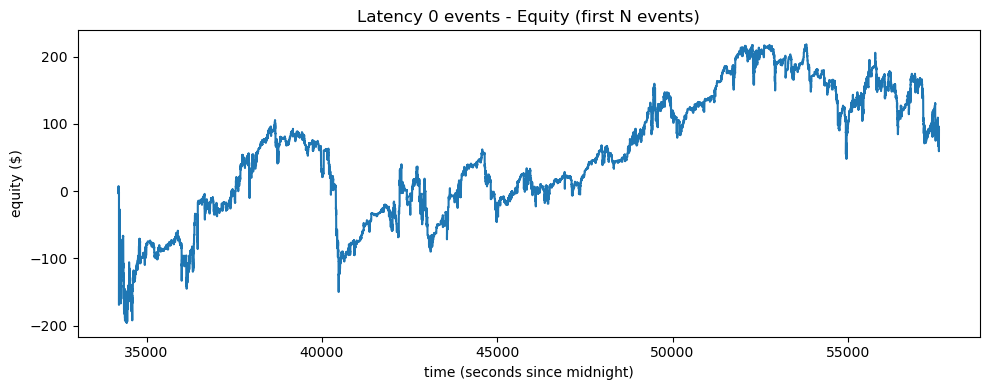

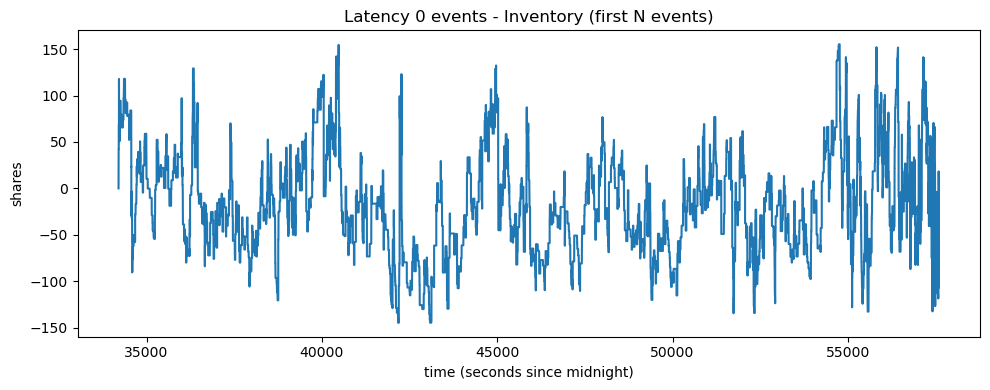

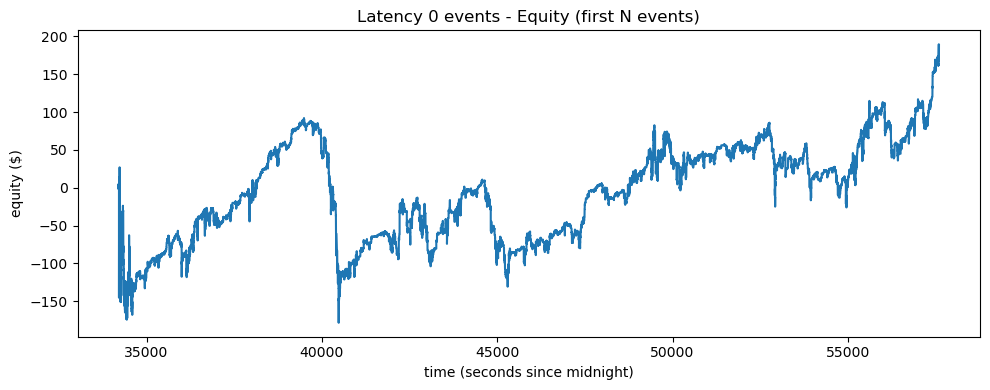

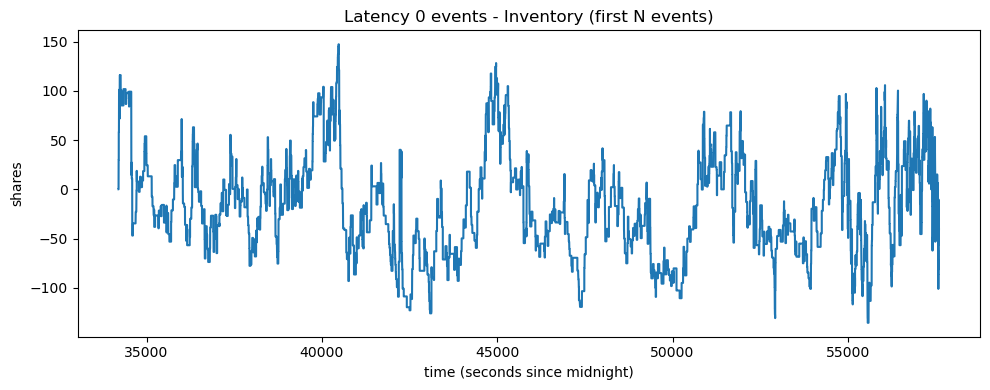

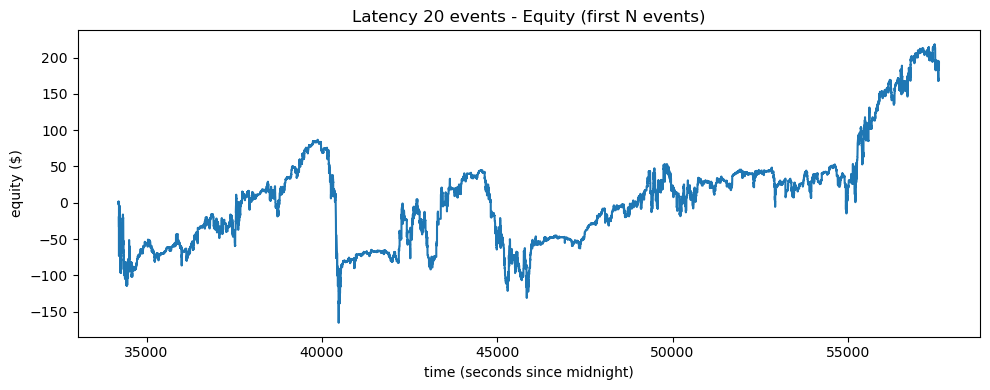

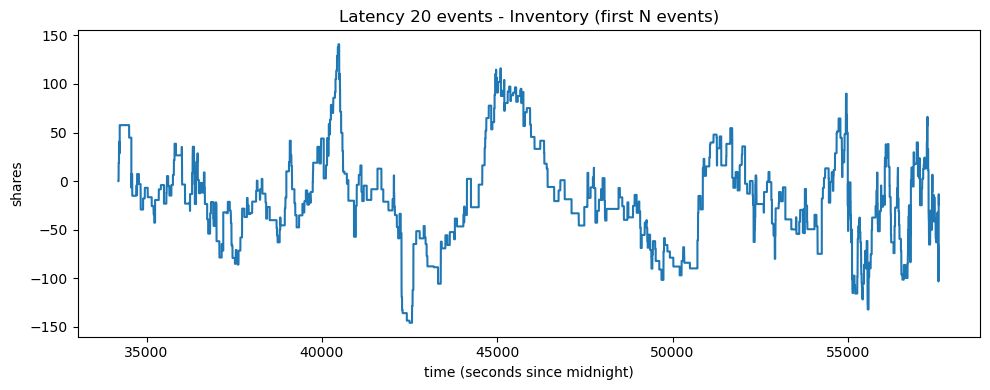

In [62]:
def plot_equity_inventory(res: pd.DataFrame, title_prefix: str, N: int = 200_000):
    # Equity
    plt.figure(figsize=(10,4))
    res["equity"].iloc[:N].plot()
    plt.title(f"{title_prefix} - Equity (first N events)")
    plt.xlabel("time (seconds since midnight)")
    plt.ylabel("equity ($)")
    plt.tight_layout()
    plt.show()

    # Inventory
    plt.figure(figsize=(10,4))
    res["inventory"].iloc[:N].plot()
    plt.title(f"{title_prefix} - Inventory (first N events)")
    plt.xlabel("time (seconds since midnight)")
    plt.ylabel("shares")
    plt.tight_layout()
    plt.show()

plot_equity_inventory(results[0], "Latency 0 events", N=200_000)
plot_equity_inventory(results[10], "Latency 0 events", N=200_000)
plot_equity_inventory(results[50], "Latency 20 events", N=200_000)


In [ ]:
# no-skew vs skew
params_no_skew = dict(base_params)
params_no_skew["inv_scale"] = 1000000

res_no_skew = run_mm_type4_with_quoting_rule(df, latency_events=50, **params_no_skew)
res_skew    = run_mm_type4_with_quoting_rule(df, latency_events=50, **base_params)

pd.DataFrame([
    {"policy":"no_skew", **compute_metrics(res_no_skew)},
    {"policy":"size_skew", **compute_metrics(res_skew)},
])

,policy,final_equity,max_drawdown,max_abs_inventory,total_buys,total_sells,total_trades
0,no_skew,1202.340599,-302.692508,224.695111,4299.744113,4459.027393,8758.771506
1,size_skew,192.599021,-252.149718,145.711410,4509.566533,4533.550091,9043.116624
